### loading packages

In [1]:
import pandas as pd
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

### loading data

In [2]:
zf = zipfile.ZipFile('../Data/Base.csv.zip') 
df = pd.read_csv(zf.open('Base.csv'))

In [3]:
df.shape

(1000000, 32)

In [4]:
df.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

In [5]:
df['fraud_bool'].value_counts()

0    988971
1     11029
Name: fraud_bool, dtype: int64

### data cleaning

The column __device_fraud_count__ is useless, and therefore drop it.

In [6]:
df = df.drop(['device_fraud_count'], axis=1) 

Delete missing data (-1)

In [7]:
df = df[df.bank_months_count != -1]
df = df[df.session_length_in_minutes != -1]
df = df[df.device_distinct_emails_8w != -1] 

In [8]:
df.shape

(745515, 31)

In [9]:
df['fraud_bool'].value_counts()

0    738632
1      6883
Name: fraud_bool, dtype: int64

#### UnderSample

重新分配label，使得label0的数量是label1数量的4倍

In [10]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

In [11]:
X = df.drop('fraud_bool', axis=1)
y = df['fraud_bool']

In [12]:
target_count = pd.Series(y).value_counts()

target_count_1 = target_count[1]
target_count_0 = int(target_count_1 * 4)
sampling_strategy = {0: target_count_0, 1: target_count_1}

In [13]:
under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X, y)

print("After resampling:")
print(pd.Series(y_train_resampled).value_counts())

After resampling:
0    27532
1     6883
Name: fraud_bool, dtype: int64


In [14]:
df_resampled = pd.concat([X_train_resampled,y_train_resampled],axis=1)
df_resampled.shape

(34415, 31)

#### Set categorical variables(exclude response 'fraud_bool')

In [15]:
cate_var = ['payment_type','employment_status','housing_status',
                     'source','device_os','email_is_free','phone_home_valid',
                     'phone_mobile_valid','has_other_cards','foreign_request',
                     'keep_alive_session','month']

In [16]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
one_hot_encoded_data = encoder.fit_transform(df_resampled[cate_var])
columns = encoder.get_feature_names_out(cate_var)
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_data, columns=columns)
df_resampled_encoder = pd.concat([df_resampled.drop(cate_var,axis=1), one_hot_encoded_df], axis=1)

/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [48]:
df = df_resampled_encoder
df.shape

(34415, 65)

#### Train test split

In [18]:
X = df.drop('fraud_bool',axis=1)
y = df['fraud_bool']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X.shape)

(34415, 64)


### Model

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

#### KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 31), 'weights': ['uniform', 'distance']}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train[:3000], y_train[:3000])

best_knn_params = grid_search.best_params_
best_knn_estimator = grid_search.best_estimator_

print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'n_neighbors': 30, 'weights': 'distance'}


In [24]:
best_knn_model = KNeighborsClassifier(**best_knn_params)
best_knn_model.fit(X_train,y_train)
y_knn_pred = best_knn_model.predict(X_test)
y_knn_pred_proba = best_knn_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[8140   52]
 [2058   75]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      8192
           1       0.59      0.04      0.07      2133

    accuracy                           0.80     10325
   macro avg       0.69      0.51      0.48     10325
weighted avg       0.76      0.80      0.72     10325


Accuracy Score:
0.7956416464891041


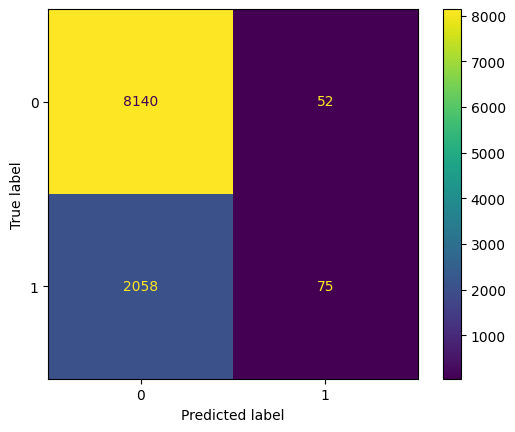

In [25]:
cm = confusion_matrix(y_test, y_knn_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_knn_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_knn_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_knn_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_knn_pred))

#### GBDT

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
gbdt = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(gbdt, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train[:3000], y_train[:3000])

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='roc_auc')

In [31]:
best_gbdt_params = grid_search.best_params_
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 200, 'subsample': 0.9}


In [32]:
best_gbdt_model = GradientBoostingClassifier(**best_gbdt_params)
best_gbdt_model.fit(X_train,y_train)
y_gbdt_pred = best_gbdt_model.predict(X_test)
y_gbdt_pred_proba = best_gbdt_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[7849  343]
 [1067 1066]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      8192
           1       0.76      0.50      0.60      2133

    accuracy                           0.86     10325
   macro avg       0.82      0.73      0.76     10325
weighted avg       0.85      0.86      0.85     10325


Accuracy Score:
0.8634382566585956


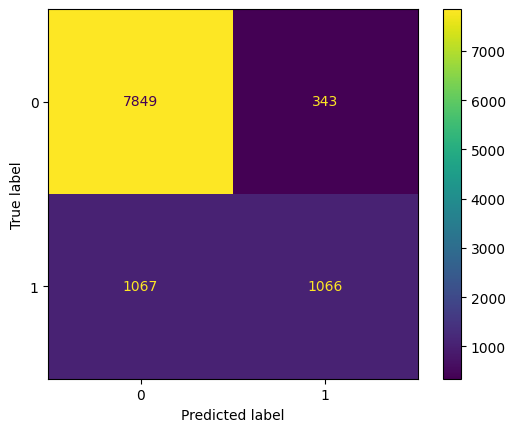

In [39]:
cm = confusion_matrix(y_test, y_gbdt_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_gbdt_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_gbdt_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_gbdt_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_gbdt_pred))

#### XGBoost

In [34]:
from xgboost import XGBClassifier


In [35]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train[:3000], y_train[:3000])


/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='roc_auc')

In [36]:
best_xgb_params = grid_search.best_params_
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [37]:
best_xgb_model = XGBClassifier(**best_xgb_params)
best_xgb_model.fit(X_train,y_train)
y_xgb_pred = best_xgb_model.predict(X_test)
y_xgb_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[7898  294]
 [1129 1004]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      8192
           1       0.77      0.47      0.59      2133

    accuracy                           0.86     10325
   macro avg       0.82      0.72      0.75     10325
weighted avg       0.85      0.86      0.85     10325


Accuracy Score:
0.862179176755448


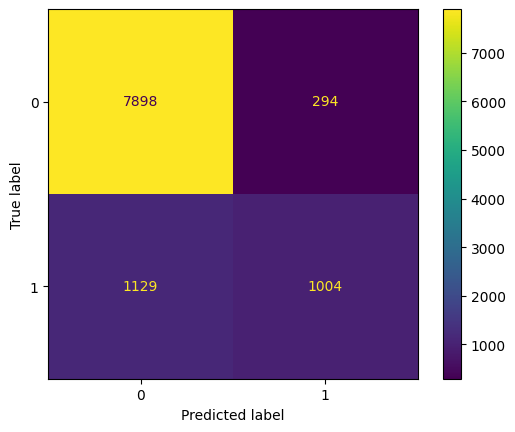

In [38]:
cm = confusion_matrix(y_test, y_xgb_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_xgb_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_xgb_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_xgb_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_xgb_pred))

#### MLP

In [40]:
from sklearn.neural_network import MLPClassifier

In [43]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'batch_size': [32, 64, 128],
    'max_iter': [100, 200, 300],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.01],
    'learning_rate': ['adaptive'],
    'learning_rate_init': [0.1]
}

mlp_model = MLPClassifier(random_state=42)
grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=5, 
                           scoring='roc_auc', n_jobs=64)
grid_search.fit(X_train[:3000], y_train[:3000])

/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
 

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=42), n_jobs=64,
             param_grid={'activation': ['relu', 'tanh'], 'alpha': [0.01],
                         'batch_size': [32, 64, 128],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 100)],
                         'learning_rate': ['adaptive'],
                         'learning_rate_init': [0.1],
                         'max_iter': [100, 200, 300], 'solver': ['adam']},
             scoring='roc_auc')

In [44]:
best_mlp_params = grid_search.best_params_
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'activation': 'relu', 'alpha': 0.01, 'batch_size': 32, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'max_iter': 100, 'solver': 'adam'}


In [45]:
best_mlp_model = MLPClassifier(**best_mlp_params)
best_mlp_model.fit(X_train,y_train)
y_mlp_pred = best_mlp_model.predict(X_test)
y_mlp_pred_proba = best_mlp_model.predict_proba(X_test)[:, 1]

Confusion Matrix:
[[8192    0]
 [2133    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      8192
           1       0.00      0.00      0.00      2133

    accuracy                           0.79     10325
   macro avg       0.40      0.50      0.44     10325
weighted avg       0.63      0.79      0.70     10325


Accuracy Score:
0.7934140435835351


/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

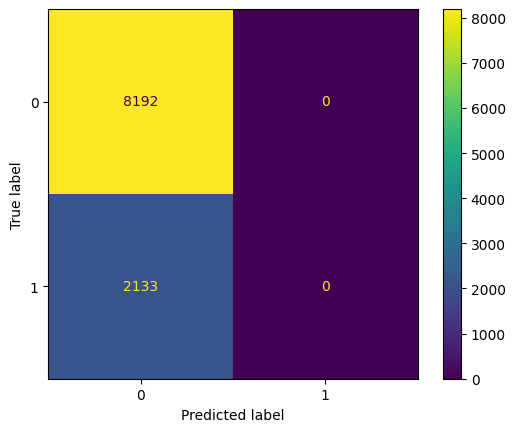

In [46]:
cm = confusion_matrix(y_test, y_mlp_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_mlp_model.classes_)
cm_display.plot();
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_mlp_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_mlp_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_mlp_pred))